<a href="https://colab.research.google.com/github/twishabosegithub/Detecting-Fraudulent-Job-Postings-using-Structured-Features-and-NLP/blob/main/Pattern_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Pattern Recognition & Anomaly Detection Mini Project: Detecting Fraudulent Job Postings using Structured Features and NLP


# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import re
import string


<ipython-input-3-8f93904406b3>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='fraudulent', palette='Set2')


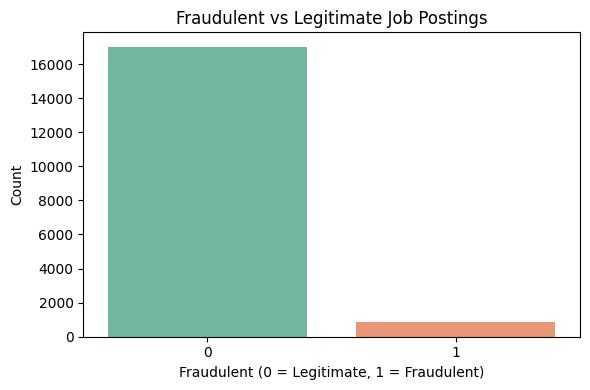

In [ ]:
# Load dataset
df = pd.read_csv('/content/fake_job_postings.csv')

# -----------------------------------
# Exploratory Data Analysis (EDA)
# -----------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fraudulent', palette='Set2')
plt.title('Fraudulent vs Legitimate Job Postings')
plt.xlabel('Fraudulent (0 = Legitimate, 1 = Fraudulent)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------
# Data Cleaning
# -----------------------------------
text_columns = ['title', 'location', 'description', 'requirements', 'benefits', 'company_profile']
for col in text_columns:
    df[col] = df[col].fillna('').astype(str)

# Text Preprocessing Function
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub("\\d+", "", text)
    text = re.sub("\\s+", " ", text).strip()
    return text

# Combine and clean text
full_text_raw = df['title'] + ' ' + df['location'] + ' ' + df['description'] + ' ' + \
                df['requirements'] + ' ' + df['benefits'] + ' ' + df['company_profile']
df['full_text'] = full_text_raw.apply(clean_text)


In [ ]:
# -----------------------------------
# Feature Engineering
# -----------------------------------
df['has_salary'] = df['salary_range'].notna().astype(int)
df['has_company_logo'] = df['has_company_logo'].astype(int)
df['has_questions'] = df['has_questions'].astype(int)
df['description_length'] = df['description'].str.len()
df['requirements_length'] = df['requirements'].str.len()
df['title_length'] = df['title'].str.len()


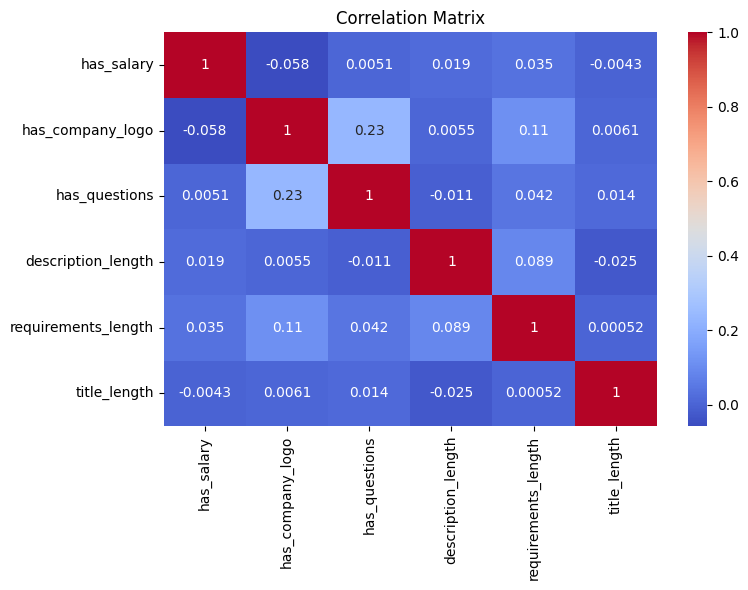

In [ ]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df[['has_salary', 'has_company_logo', 'has_questions',
                'description_length', 'requirements_length', 'title_length']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

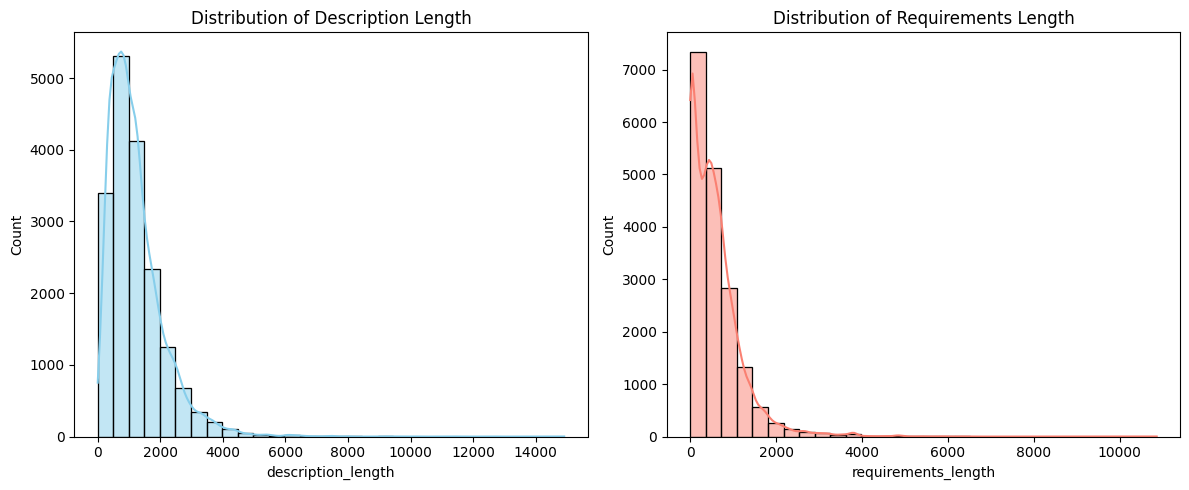

In [ ]:
# Length Distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['description_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Description Length')

plt.subplot(1, 2, 2)
sns.histplot(df['requirements_length'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Requirements Length')
plt.tight_layout()
plt.show()

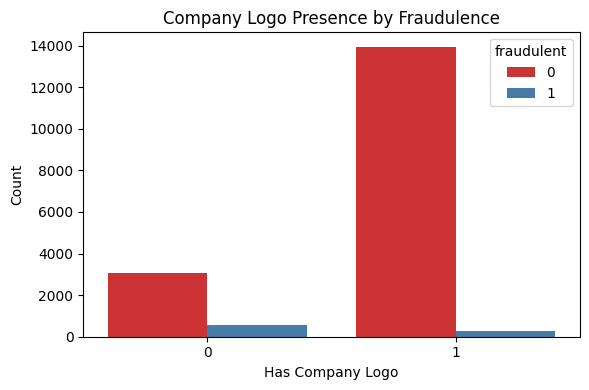

In [ ]:
# Company Logo Presence by Fraudulence
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='has_company_logo', hue='fraudulent', palette='Set1')
plt.title('Company Logo Presence by Fraudulence')
plt.xlabel('Has Company Logo')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------
# Prepare Data for Modeling
# -----------------------------------
X_structured = df[['has_salary', 'has_company_logo', 'has_questions',
                   'description_length', 'requirements_length', 'title_length']]
y = df['fraudulent']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = vectorizer.fit_transform(df['full_text']).toarray()


In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_structured, y, test_size=0.2, random_state=42)
X_text_train, X_text_test, _, _ = train_test_split(X_text, y, test_size=0.2, random_state=42)


Random Forest Performance on Structured Features:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3395
           1       0.81      0.44      0.57       181

    accuracy                           0.97      3576
   macro avg       0.89      0.72      0.78      3576
weighted avg       0.96      0.97      0.96      3576

ROC-AUC Score (Structured Model): 0.9065858957355226


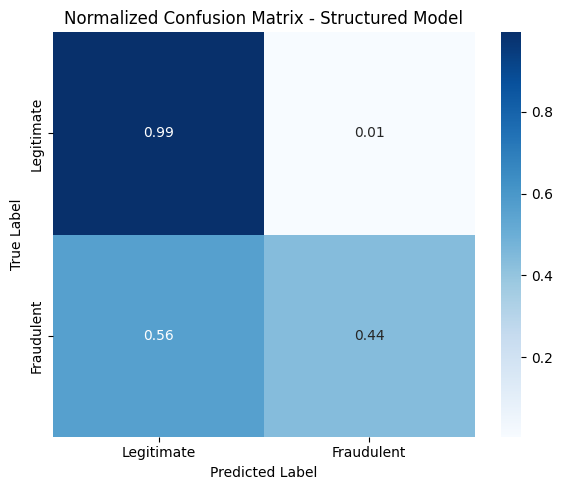

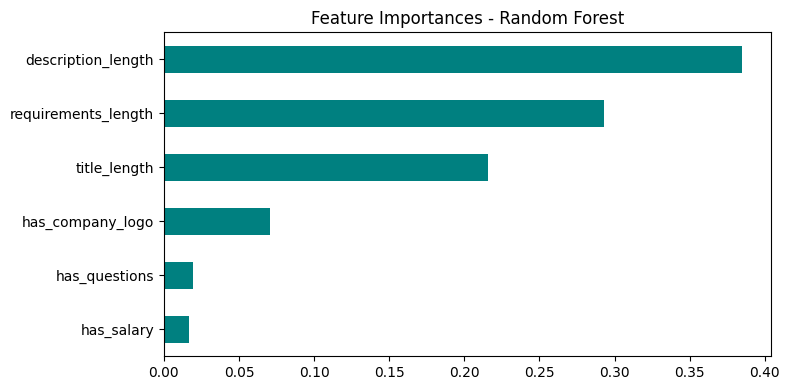

In [ ]:
# -----------------------------------
# Random Forest on Structured Features
# -----------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest Performance on Structured Features:\n")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score (Structured Model):", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Structured Model')
plt.tight_layout()
plt.show()

# Feature Importances
feat_importances = pd.Series(rf.feature_importances_, index=X_structured.columns)
feat_importances.sort_values().plot(kind='barh', color='teal', figsize=(8, 4))
plt.title('Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

Combined Model Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.96      0.63      0.76       181

    accuracy                           0.98      3576
   macro avg       0.97      0.81      0.87      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC Score: 0.8141807500467864


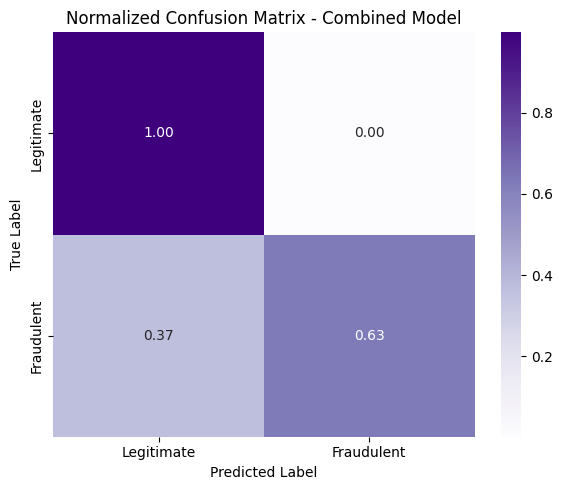

In [ ]:
# -----------------------------------
# Combined Features Model (Structured + TF-IDF)
# -----------------------------------
X_combined_train = np.hstack((X_train, X_text_train))
X_combined_test = np.hstack((X_test, X_text_test))

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_combined_train, y_train)

rf_combined = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_combined.fit(X_train_resampled, y_train_resampled)
y_pred_combined = rf_combined.predict(X_combined_test)

print("Combined Model Classification Report:\n", classification_report(y_test, y_pred_combined))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_combined))

cm_combined = confusion_matrix(y_test, y_pred_combined)
cm_combined_normalized = cm_combined.astype('float') / cm_combined.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_combined_normalized, annot=True, fmt='.2f', cmap='Purples',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Combined Model')
plt.tight_layout()
plt.show()


